# Task 2.1

“Given a video of the modal mask of an object, predict the amodal mask of the same object”

Inputs:
- RGB Frames - N 3-channel images (N, 3, 256, 256)
- N Modal Masks of Object i - N Binary (1-channel) images (N, 1, 256, 256)

Outputs:
- N Amodal Masks of Object i - N Binary (1-channel) images (1, 256, 256)

In [1]:
# PyTorch, Torchvision
import torch
from torch import nn
from torchvision.transforms import ToPILImage, ToTensor
from torchvision.utils import make_grid
from torchvision.io import write_video

# Common
from pathlib import Path
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random
import json
from IPython.display import Video

# Utils from Torchvision
tensor_to_image = ToPILImage()
image_to_tensor = ToTensor()

In [2]:
torch.cuda.is_available()

True

In [3]:
!nvidia-smi

Fri Jul 18 16:09:13 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 575.57.08              Driver Version: 575.57.08      CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla M60                      On  |   00000000:04:00.0 Off |                    0 |
| N/A   24C    P8             15W /  150W |       3MiB /   7680MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Figures

In [97]:

# Single sample video comparison
def make_comparison_grid(
    scene_rgb, scene_modal_mask,
    gt_amodal_rgb, gt_amodal_mask,
    pred_amodal_rgb, pred_amodal_mask,
    n_frames=24):
    """
    Makes a grid_tensor for a 3 row by 2 column video
    """

    grid_tensors = []
    for i in range(n_frames):
        # Select the i-th frame for each tensor
        scene_rgb_frame = scene_rgb[:, i]                 # (3, H, W)
        scene_mask_frame = scene_modal_mask[:, i]         # (1 or 3, H, W)
        gt_rgb_frame = gt_amodal_rgb[:, i]                # (3, H, W)
        gt_mask_frame = gt_amodal_mask[:, i]              # (1 or 3, H, W)
        pred_rgb_frame = pred_amodal_rgb[:, i]            # (3, H, W)
        pred_mask_frame = pred_amodal_mask[:, i]          # (1 or 3, H, W)

        # If mask is single-channel, repeat to 3 channels for visualization
        if scene_mask_frame.shape[0] == 1:
            scene_mask_frame = scene_mask_frame.repeat(3, 1, 1)
        if gt_mask_frame.shape[0] == 1:
            gt_mask_frame = gt_mask_frame.repeat(3, 1, 1)
        if pred_mask_frame.shape[0] == 1:
            pred_mask_frame = pred_mask_frame.repeat(3, 1, 1)

        # Top row: Scene RGB | Scene modal mask
        top_row = [scene_rgb_frame, scene_mask_frame]
        # Middle row: GT amodal RGB | GT amodal mask
        middle_row = [gt_rgb_frame, gt_mask_frame]
        # Bottom row: Pred amodal RGB | Pred amodal mask
        bottom_row = [pred_rgb_frame, pred_mask_frame]

        # Stack all rows horizontally (2 columns per row, 3 rows)
        grid = top_row + middle_row + bottom_row  # [6 tensors]
        grid_img = make_grid(grid, nrow=2, padding=2, pad_value=127)
        grid_tensors.append(grid_img)
    return grid_tensors


In [98]:
# Single sample video comparison
def make_model_comparison_grid(scene_rgb, scene_modal_mask,
                               gt_amodal_rgb, gt_amodal_mask,
                               pred1_amodal_rgb, pred1_amodal_mask,
                               pred2_amodal_rgb, pred2_amodal_mask,
                               padding=2, pad_value=127, n_per_row=2):
    """
    Makes a grid_tensor for a 4 row by 2 column video
    Compares inputs and ground truth to output from two models
    """
    # Infer frames from the second dim
    n_frames = scene_rgb.shape[1]
    print(n_frames)
    grid_tensors = []
    for i in range(n_frames):
        # Select the i-th frame for each tensor
        scene_rgb_frame = scene_rgb[:, i]                 # (3, H, W)
        scene_mask_frame = scene_modal_mask[:, i]         # (1 or 3, H, W)
        gt_rgb_frame = gt_amodal_rgb[:, i]                # (3, H, W)
        gt_mask_frame = gt_amodal_mask[:, i]              # (1 or 3, H, W)
        pred1_rgb_frame = pred1_amodal_rgb[:, i]            # (3, H, W)
        pred1_amask_frame = pred1_amodal_mask[:, i]          # (1 or 3, H, W)
        pred2_rgb_frame = pred2_amodal_rgb[:, i]            # (3, H, W)
        pred2_amask_frame = pred2_amodal_mask[:, i]          # (1 or 3, H, W)

        # If mask is single-channel, repeat to 3 channels for visualization
        if scene_mask_frame.shape[0] == 1:
            scene_mask_frame = scene_mask_frame.repeat(3, 1, 1)
        if gt_mask_frame.shape[0] == 1:
            gt_mask_frame = gt_mask_frame.repeat(3, 1, 1)
        if pred1_amask_frame.shape[0] == 1:
            pred1_amask_frame = pred1_amask_frame.repeat(3, 1, 1)
        if pred2_amask_frame.shape[0] == 1:
            pred2_amask_frame = pred2_amask_frame.repeat(3, 1, 1)

        # Top row: Scene RGB | Scene modal mask
        row1 = [scene_rgb_frame, scene_mask_frame, gt_rgb_frame, gt_mask_frame]
        # Middle row: GT amodal RGB | GT amodal mask
        row2 = [pred1_rgb_frame, pred1_amask_frame, pred2_rgb_frame, pred2_amask_frame]
        # # Bottom row: Pred Mod1 amodal RGB | Pred Mod1 amodal mask
        # row3 = []
        # # Bottom row: Pred Mod2 amodal RGB | Pred Mod2 amodal mask
        # row4 = []

        # Stack all rows horizontally (2 columns per row, 4 rows)
        grid = row1 + row2  # [8 tensors]
        # nrow is num of images per row
        grid_img = make_grid(grid, nrow=n_per_row, padding=padding, pad_value=pad_value)
        grid_tensors.append(grid_img)
    return grid_tensors


In [99]:
# Quick video
def make_vid(grid_tensors, save_path):
    vid_tensor = torch.stack(grid_tensors, dim=1).permute(1, 2, 3, 0)
    vid_tensor = (vid_tensor*255).long()
    write_video(save_path, vid_tensor, fps=5, options={'crf':'20'})


# Make matplotlib video with titles
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import torch

def make_grid_video_with_titles(grid_tensors, 
                                panel_titles=[['Input RGB', 'Input Modal Mask'],
                                              ['True Amodal RGB', 'True Amodal Mask'],
                                              ['Pred Amodal RGB', 'Pred Amodal Mask']], 
                                nrows=3, ncols=2, figsize=(8, 12), 
                                title_fontsize=12,
                                interval=200, save_path=None):
    """
    Writes a 2-column, 3-row video. 

    grid_tensors: list of torch.Tensor, each of shape (3, H, W), values in [0,1] or [0,255]
    panel_titles: 2D list of strings, shape (nrows, ncols)
    interval: time between frames in ms
    save_path: if not None, saves animation to this path (e.g., 'output.mp4')
    """
    # Prepare figure and axes
    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes if isinstance(axes, np.ndarray) else np.array([[axes]])

    assert np.array(panel_titles).shape == axes.shape

    # Compute panel height and width from first frame
    img = grid_tensors[0].cpu()
    # Always convert to uint8 for display
    if img.dtype != torch.uint8:
        img = (img * 255).clamp(0, 255).byte()
    img_np = img.permute(1, 2, 0).numpy()  # (H, W, 3)

    # Debug: print min/max for first frame
    print(f"First frame min: {img_np.min()}, max: {img_np.max()}, dtype: {img_np.dtype}")

    H, W, _ = img_np.shape
    panel_h = H // nrows
    panel_w = W // ncols

    # Set titles and initialize images
    ims = []
    for i in range(nrows):
        row = []
        for j in range(ncols):
            ax = axes[i, j]
            ax.set_title(panel_titles[i][j], fontsize=title_fontsize)
            ax.axis('off')
            # Dummy initial image
            panel = img_np[i*panel_h:(i+1)*panel_h, j*panel_w:(j+1)*panel_w]
            im = ax.imshow(panel)
            row.append(im)
        ims.append(row)

    def update(frame_idx):
        img = grid_tensors[frame_idx].cpu()
        if img.dtype != torch.uint8:
            img = (img * 255).clamp(0, 255).byte()
        img_np = img.permute(1, 2, 0).numpy()
        for i in range(nrows):
            for j in range(ncols):
                y0, y1 = i * panel_h, (i + 1) * panel_h
                x0, x1 = j * panel_w, (j + 1) * panel_w
                panel = img_np[y0:y1, x0:x1]
                ims[i][j].set_data(panel)
        return sum(ims, [])

    ani = animation.FuncAnimation(fig, update, frames=len(grid_tensors), interval=interval, blit=False)
    plt.tight_layout()
    if save_path is not None:
        ani.save(save_path, writer='ffmpeg')
    else:
        plt.show()



### Model

In [4]:

def calculate_metrics(amodal_mask_preds, 
                      amodal_mask_labels, 
                      amodal_content_preds,
                      amodal_content_labels):
    """
    Here, you can calculate non-loss metrics like mIOU, accuracy, J&F scores.

    And non-loss image generation metrics between the predicted and ground-truth amodal content
    Such as Inception Score, Frechet Inception Distance, Learned Perceptual Patch Similarity (LPIPS),
    Structure Similarity Index Metric (SSIM), Peak Signal-Noise Ratio (PSNR)

    These should all have easy-to-use implementations in libraries such as TorchMetrics.
    """
    return None


In [134]:
import torch
import torch.nn as nn

class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        # inputs: logits (not sigmoid yet)
        # targets: 0 or 1
        bce_loss = nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1 - pt) ** self.gamma * bce_loss
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [5]:
# Dice and iOU
def dice_loss(preds, targets, smooth=1.):
    """
    Dice coefficient measures overlap between predicted and ground truth masks.
    """
    preds = torch.sigmoid(preds)
    preds = preds.view(-1)
    targets = targets.view(-1)
    intersection = (preds * targets).sum()
    dice = (2. * intersection + smooth) / (preds.sum() + targets.sum() + smooth)
    return 1 - dice

def iou_loss(preds, targets, smooth=1.):
    """
    IoU (Intersection over Union) - 
    Intersection of Predicted and True masks
    over Union of intersection and true
    """
    preds = torch.sigmoid(preds)
    preds = preds.view(-1)
    targets = targets.view(-1)
    intersection = (preds * targets).sum()
    total = preds.sum() + targets.sum()
    union = total - intersection
    iou = (intersection + smooth) / (union + smooth)
    return 1 - iou

In [6]:
def get_accuracy(logits_amodal_mask, amodal_mask_labels):
    # Compute accuracy
    # If preds are probabilities/logits, binarize them:
    preds_mask = logits_amodal_mask.sigmoid().round() # make binary
    true_mask = amodal_mask_labels.round() # make these binary as well
    # Ensure labels are also float or int for comparison
    # Calculate number of correct pixels
    correct = (preds_mask == true_mask).float().sum()
    # Calculate total number of pixels (numel = number of total elements)
    total = torch.numel(preds_mask)
    # Accuracy
    accuracy = correct / total # this is a number 0 to 1
    
    return accuracy

In [57]:
import torch

from torchmetrics.image.lpip import LearnedPerceptualImagePatchSimilarity

def prepare_for_lpips(x):
    """
    Converts logits to the correct format for torchmetrics LPIPS.
    - Ensures float32, [0, 1], and 3 channels.
    Args:
        x: Tensor (batch, channels, frames, H, W) or (batch, channels, H, W)
    Returns:
        Tensor (batch, 3, frames, H, W) or (batch, 3, H, W), float32 in [0, 1]
    """
    # If input is uint8, assume [0, 255] and scale
    if x.dtype == torch.uint8:
        x = x.float() / 255.0
    # If input is in [-1, 1], convert to [0, 1]
    if x.min() < 0:
        x = (x + 1) / 2.0
    # Ensure 3 channels
    if x.shape[1] > 3:
        x = x[:, :3]
    elif x.shape[1] < 3:
        # Simple repeat if grayscale
        x = x.repeat(1, 3, *([1] * (x.dim() - 2)))
    return x

def lpips_over_frames_torchmetrics(preds, targets, lpips_func):
    """
    Computes average LPIPS over frames and batch using torchmetrics LPIPS.
    Remember, lower LPIPS means higher perceptual similarity (optimal is zero)
    Args:
        lpips_metric: An instance of torchmetrics.LearnedPerceptualImagePatchSimilarity.
        preds: Tensor of shape (batch, channels, frames, H, W)
        targets: Tensor of same shape as preds.
    Returns:
        Scalar tensor: average LPIPS over all frames and batch.
    """
    # Goes from logits to range of [-1, 1] expected by LPIPS
    preds = prepare_for_lpips(preds)
    targets = prepare_for_lpips(targets)
    batch, channels, num_frames, H, W = preds.shape
    scores = []
    for t in range(num_frames):
        pred_frame = preds[:, :, t, :, :]    # (batch, 3, H, W)
        target_frame = targets[:, :, t, :, :]
        score = lpips_func(pred_frame, target_frame)  # (batch,) or scalar
        if score.dim() == 0:
            score = score.unsqueeze(0)  # Make it (1,)
        scores.append(score)
    scores = torch.stack(scores, dim=1)  # (batch, frames)
    return scores.mean()


#### Class - Unet_Image

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class conv2d_inplace_spatial(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, pooling_function, activation = nn.GELU()):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(out_channels),
            nn.GELU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=(3, 3), padding=(1, 1)),
            nn.BatchNorm2d(out_channels),
            activation,
            pooling_function,
        )

    def forward(self, x):
        return self.double_conv(x)
    
class Upscale(nn.Module):
    def __init__(self, scale_factor=(2, 2), mode='bilinear', align_corners=False):
        super(Upscale, self).__init__()
        self.scale_factor = scale_factor
        self.mode = mode
        self.align_corners = align_corners

    def forward(self, x):
        return F.interpolate(x, scale_factor=self.scale_factor, mode=self.mode, align_corners=self.align_corners)

class Unet_Image(nn.Module):
    def __init__(self, in_channels = 4, mask_content_preds = False):
        super().__init__()
        # downsampling
        # MaxPooling - keep max value over a 2x2 sliding window
        self.mpool_2 = nn.MaxPool2d((2, 2))
        
        # down path - encoding - increase dimensions
        self.down1 = conv2d_inplace_spatial(in_channels, 32, self.mpool_2) # 32 x 32
        self.down2 = conv2d_inplace_spatial(32, 64, self.mpool_2) # 64 x64 
        self.down3 = conv2d_inplace_spatial(64, 128, self.mpool_2) # 128 x128
        self.down4 = conv2d_inplace_spatial(128, 256, self.mpool_2) # outputs 256 x256
        
        # upsample by factor of 2, in both dimensions
        self.upscale_2 = Upscale(scale_factor=(2, 2), mode='bilinear', align_corners=False)
        
        # up path - decoder
        # slowly reduce dimensions
        self.up1 = conv2d_inplace_spatial(256, 128, self.upscale_2)
        self.up2 = conv2d_inplace_spatial(256, 64, self.upscale_2)
        self.up3 = conv2d_inplace_spatial(128, 32, self.upscale_2)
        
        # no activation
        self.up4_amodal_mask = conv2d_inplace_spatial(64, 1, self.upscale_2, activation = nn.Identity())
        self.up4_amodal_content = conv2d_inplace_spatial(64, 3, self.upscale_2, activation = nn.Identity())

        # Optional arguments
        self.mask_content_preds = mask_content_preds # Should we mask the amodal content prediction by the amodal mask prediction?

        # Optimization
        self.mse_loss = nn.L1Loss()
        self.bce_loss = nn.BCEWithLogitsLoss()


        # Self-attention feature enrichment
        #max_seq = 16*16*6
        #token_dim = 256
        #self.pos_enc = nn.Parameter(torch.zeros((max_seq, 1, token_dim))) # seq b dim
        #encoder_layer = nn.TransformerEncoderLayer(d_model=token_dim, nhead=8)
        #self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=4)
    
    # Packages the encoder path (downpath)
    def encode(self, x):
        x1 = self.down1(x)
        x2 = self.down2(x1)
        x3 = self.down3(x2)
        x4 = self.down4(x3)
        
        # Returns the four
        # [torch.Size([6, 32, 4, 128, 128]), torch.Size([6, 64, 2, 64, 64]), torch.Size([6, 128, 1, 32, 32]), torch.Size([6, 256, 1, 16, 16])]
        return x1, x2, x3, x4
    
    # packages the decode path (up-path)
    def decode(self, h1, h2, h3, h4):
        h4 = self.up1(h4) # 6, 256, 1, 16, 16 -> 6, 128, 1, 32, 32 (double spatial, then conv-in-place channels to half)
        h34 = torch.cat((h3, h4), dim = 1) # (6, 2*128, 1, 32, 32)

        h34 = self.up2(h34) # 6, 256, 1, 32, 32 -> 6, 128, 2, 64, 64
        h234 = torch.cat((h2, h34), dim = 1)

        h234 = self.up3(h234)
        h1234 = torch.cat((h1, h234), dim = 1)
        
        logits_amodal_mask = self.up4_amodal_mask(h1234)
        logits_amodal_content = self.up4_amodal_content(h1234)
        return logits_amodal_mask, logits_amodal_content
    
    # Encode - decode together
    # Runs through the whole model
    def encode_decode(self, x):
        """
        input image tensor: (bs, c, h, w) - batch size, channels, height, width
        """
        b, c, h, w = x.shape

        # Multiscale features x1, x2, x3, x4
        x1, x2, x3, x4 = self.encode(x)

        # You could add code here for example more layers that modify the latent x4? Be creative :)

        # Decode using enriched features
        logits_amodal_mask, logits_amodal_content = self.decode(x1, x2, x3, x4)

        return logits_amodal_mask, logits_amodal_content
        
    def forward(self, batch):
        # This takes in a batch
        # RGB image batch of shape (bs, c, n_frames, h, w)
        # modal_mask (binary, c=1) batch of shape (bs, c, n_frames, h, w)
        # concat rgb and modal masks as input to model
        model_input = torch.cat((batch['frames'], batch['modal_masks']), dim = 1)

        # Remove time dimension from a few things (add it back in later when you make your video model!)
        model_input = model_input.squeeze(2) # remove time dimension (you will probably want it later!)
        # This is what we use for loss calculations
        # These both have range 0 to 1 - same to logits
        amodal_mask_labels = batch['amodal_masks'].float().squeeze(2)
        amodal_content_labels = batch['amodal_content'].float().squeeze(2)

        # Model input
        #print('model input:', model_input.shape)
        
        logits_amodal_mask, logits_amodal_content = self.encode_decode(model_input)

        # Should we mask the amodal content prediction by the predicted amodal mask?
        if self.mask_content_preds:
            # Element-wise masking by self-predictions:
            logits_amodal_content = logits_amodal_mask.sigmoid().round() * logits_amodal_content

        # print('0000 Verify Shapes 0000')
        # print(logits_amodal_mask.shape)
        # print(logits_amodal_content.shape)
        # print(amodal_mask_labels.shape)
        # print(amodal_content_labels.shape)
        # Loss between predicted amodal masks/content and GT masks/content
        mask_loss, content_loss = self.loss_function(logits_amodal_mask, 
                                                        amodal_mask_labels,
                                                        logits_amodal_content, 
                                                        amodal_content_labels)
        
        loss = mask_loss + content_loss

        # Calculate metrics into a dictionary
        metrics = calculate_metrics(logits_amodal_mask, 
                                    amodal_mask_labels, 
                                    logits_amodal_content,
                                    amodal_content_labels)
        
        # Report the metrics we calculated in addition to our loss functions
        metrics = {
            'loss': loss.data.item(),
            'mask_loss': mask_loss.data.item(),
            'content_loss': content_loss.data.item(),
            'other_metrics_to_monitor': 0 # add more metrics here - just make sure they are a number
        }
        return loss, metrics
    def loss_function(self,
                    amodal_mask_preds,
                    amodal_mask_labels,
                    amodal_content_preds,
                    amodal_content_labels):
        # Compares raw logits for binary prediction - object vs no object
        mask_loss = self.bce_loss(amodal_mask_preds, amodal_mask_labels) # Binary Cross Entropy Loss
        # Pixel by pixel difference in the RGB
        content_loss = self.mse_loss(amodal_content_preds, amodal_content_labels) # L1 loss
        return mask_loss, content_loss

#### Example Usage

Test model usage

In [9]:
# Make a U-net which expects a batch of 4-channel images as input (batch_size, channels=4, height, width)
model = Unet_Image(4)

# Make a dummy tensor to test the model can successfully apply its layers and get an output
batch_size = 1
rand_input = torch.randn((batch_size, 4, 256, 256))

# Apply the model to the input - we use encode decode here rather than forward
# because we don't have the full batch yet - we will later
logits_amodal_mask, logits_amodal_content = model.encode_decode(rand_input)
print('Model output:', logits_amodal_mask.shape, logits_amodal_content.shape)
del logits_amodal_mask, logits_amodal_content
# For our use-case, we are predicting amodal masks and amodal content
# The amodal mask prediction should be (batch_size, 1, h, w) for a binary mask and the 
# Amodal content prediction should be  (batch_size, 3, h, w) for an rgb object prediction

Model output: torch.Size([1, 1, 256, 256]) torch.Size([1, 3, 256, 256])


## ConvLSTM + Unet

### ConvLSTM definitions

Shi et al., 2015, convolutional LSTM https://doi.org/10.48550/arXiv.1506.04214

In [58]:
# from https://github.com/ndrplz/ConvLSTM_pytorch/blob/master/convlstm.py
# import torch.nn as nn
# import torch

# This processes one time step at a time
class ConvLSTMCell(nn.Module):

    def __init__(self, input_dim, hidden_dim, kernel_size, bias):
        """
        Initialize ConvLSTM cell.

        Parameters
        ----------
        input_dim: int
            Number of channels of input tensor.
        hidden_dim: int
            Number of channels of hidden state.
        kernel_size: (int, int)
            Size of the convolutional kernel.
        bias: bool
            Whether or not to add the bias.
        """

        super(ConvLSTMCell, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.kernel_size = kernel_size
        self.padding = kernel_size[0] // 2, kernel_size[1] // 2
        self.bias = bias

        # 2d convolution
        self.conv = nn.Conv2d(in_channels=self.input_dim + self.hidden_dim,
                              out_channels=4 * self.hidden_dim,
                              kernel_size=self.kernel_size,
                              padding=self.padding,
                              bias=self.bias)

    def forward(self, input_tensor, cur_state):
        h_cur, c_cur = cur_state

        combined = torch.cat([input_tensor, h_cur], dim=1)  # concatenate along channel axis

        combined_conv = self.conv(combined)
        cc_i, cc_f, cc_o, cc_g = torch.split(combined_conv, self.hidden_dim, dim=1)
        i = torch.sigmoid(cc_i)
        f = torch.sigmoid(cc_f)
        o = torch.sigmoid(cc_o)
        g = torch.tanh(cc_g)

        c_next = f * c_cur + i * g
        h_next = o * torch.tanh(c_next)

        return h_next, c_next

    def init_hidden(self, batch_size, image_size):
        height, width = image_size
        return (torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device),
                torch.zeros(batch_size, self.hidden_dim, height, width, device=self.conv.weight.device))


# Stacks multiple LSTM cells on top of each other
class ConvLSTM(nn.Module):

    """

    Parameters:
        input_dim: Number of channels in input
        hidden_dim: Number of hidden channels
        kernel_size: Size of kernel in convolutions
        num_layers: Number of LSTM layers stacked on each other
        batch_first: Whether or not dimension 0 is the batch or not
        bias: Bias or no bias in Convolution
        return_all_layers: Return the list of computations for all layers
        Note: Will do same padding.

    Input:
        A tensor of size B, T, C, H, W or T, B, C, H, W (T=time)
    Output:
        A tuple of two lists of length num_layers (or length 1 if return_all_layers is False).
            0 - layer_output_list is the list of lists of length T of each output
            1 - last_state_list is the list of last states
                    each element of the list is a tuple (h, c) for hidden state and memory
    Example:
        >> x = torch.rand((32, 10, 64, 128, 128))
        >> convlstm = ConvLSTM(64, 16, 3, 1, True, True, False)
        >> _, last_states = convlstm(x)
        >> h = last_states[0][0]  # 0 for layer index, 0 for h index
    """

    def __init__(self, input_dim, hidden_dim, kernel_size, num_layers,
                 batch_first=False, bias=True, return_all_layers=False):
        super(ConvLSTM, self).__init__()

        self._check_kernel_size_consistency(kernel_size)

        # Make sure that both `kernel_size` and `hidden_dim` are lists having len == num_layers
        kernel_size = self._extend_for_multilayer(kernel_size, num_layers)
        hidden_dim = self._extend_for_multilayer(hidden_dim, num_layers)
        if not len(kernel_size) == len(hidden_dim) == num_layers:
            raise ValueError('Inconsistent list length.')

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        self.batch_first = batch_first
        self.bias = bias
        self.return_all_layers = return_all_layers

        cell_list = []
        for i in range(0, self.num_layers):
            cur_input_dim = self.input_dim if i == 0 else self.hidden_dim[i - 1]

            cell_list.append(ConvLSTMCell(input_dim=cur_input_dim,
                                          hidden_dim=self.hidden_dim[i],
                                          kernel_size=self.kernel_size[i],
                                          bias=self.bias))

        self.cell_list = nn.ModuleList(cell_list)

    def forward(self, input_tensor, hidden_state=None):
        """

        Parameters
        ----------
        input_tensor: todo
            5-D Tensor either of shape (t, b, c, h, w) or (b, t, c, h, w)
        hidden_state: todo
            None. todo implement stateful

        Returns
        -------
        last_state_list, layer_output
        """
        if not self.batch_first:
            # (t, b, c, h, w) -> (b, t, c, h, w)
            input_tensor = input_tensor.permute(1, 0, 2, 3, 4)

        b, _, _, h, w = input_tensor.size()

        # Implement stateful ConvLSTM
        if hidden_state is not None:
            raise NotImplementedError()
        else:
            # Since the init is done in forward. Can send image size here
            hidden_state = self._init_hidden(batch_size=b,
                                             image_size=(h, w))

        layer_output_list = []
        last_state_list = []

        seq_len = input_tensor.size(1)
        cur_layer_input = input_tensor

        for layer_idx in range(self.num_layers):

            h, c = hidden_state[layer_idx]
            output_inner = []
            for t in range(seq_len):
                h, c = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :, :],
                                                 cur_state=[h, c])
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
            last_state_list.append([h, c])

        if not self.return_all_layers:
            layer_output_list = layer_output_list[-1:]
            last_state_list = last_state_list[-1:]

        return layer_output_list, last_state_list

    def _init_hidden(self, batch_size, image_size):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size, image_size))
        return init_states

    @staticmethod
    def _check_kernel_size_consistency(kernel_size):
        if not (isinstance(kernel_size, tuple) or
                (isinstance(kernel_size, list) and all([isinstance(elem, tuple) for elem in kernel_size]))):
            raise ValueError('`kernel_size` must be tuple or list of tuples')

    @staticmethod
    def _extend_for_multilayer(param, num_layers):
        if not isinstance(param, list):
            param = [param] * num_layers
        return param

In [146]:
class Unet_Image_ConvLSTM(Unet_Image):
    def __init__(self, device, in_channels=4, 
                 mask_content_preds=False,
                mask_weight=1.0, dice_weight=1.0, 
                 iou_weight=0.0, content_weight=1.0, 
                 lpips_weight=1.0,
                use_focal_loss=False, 
                 focal_alpha=0.25, focal_gamma=2.0):
        super().__init__(in_channels, mask_content_preds)
        # Inserting the convLSTM from above
        # One layer
        self.convlstm = ConvLSTM(
            input_dim=256,        # matches self.down4 out_channels
            hidden_dim=256,       # can be same as input_dim or different
            kernel_size=(5, 5),
            num_layers=2,         # Use two layers
            batch_first=True,     # input should be (batch, time, channels, h, w)
            bias=True,
            return_all_layers=False # returns only last layer
        )
        
        # Define loss function details
        self.mse_loss = nn.L1Loss()
        # Check for mask loss config
        if use_focal_loss:
            self.bce_loss = FocalLoss(alpha=focal_alpha, gamma=focal_gamma)
        else:
            self.bce_loss = nn.BCEWithLogitsLoss()
        # Content loss perceptual similarity
        self.lpips_loss = LearnedPerceptualImagePatchSimilarity(net_type='vgg').to(device)

        # Loss weights
        self.mask_weight = mask_weight
        self.dice_weight = dice_weight
        self.iou_weight = iou_weight
        self.content_weight = content_weight
        self.lpips_weight= lpips_weight


    def encode_frames(self, x, n_frames):
        # Encode each frame
        # Remember time dimension is in the second 
        x1_seq, x2_seq, x3_seq, x4_seq = [], [], [], []
        for t in range(n_frames):
            # Here we pass all batches (dim=0), for this timestep (dim=1)
            x1, x2, x3, x4 = self.encode(x[:, t, :, :])  # Each: (bs, channels, h, w)
            x1_seq.append(x1)
            x2_seq.append(x2)
            x3_seq.append(x3)
            x4_seq.append(x4)
        # Stack along time dimension
        x1_seq = torch.stack(x1_seq, dim=1)  # (bs, n_frames, channels, h, w)
        x2_seq = torch.stack(x2_seq, dim=1)
        x3_seq = torch.stack(x3_seq, dim=1)
        x4_seq = torch.stack(x4_seq, dim=1)
        return x1_seq, x2_seq, x3_seq, x4_seq
    
    
    def decode_frames(self, x1_seq, x2_seq, x3_seq, convlstm_out, n_frames):
        logits_amodal_mask_seq = []
        logits_amodal_content_seq = []

        # Time dimension is in dim = 1 (second dimension)
        for t in range(n_frames):
            h4 = convlstm_out[:, t]  # (bs, channels, h, w)
            # Use skip connections from the corresponding frame
            h1 = x1_seq[:, t]
            h2 = x2_seq[:, t]
            h3 = x3_seq[:, t]
            logits_mask, logits_content = self.decode(h1, h2, h3, h4)
            logits_amodal_mask_seq.append(logits_mask)
            logits_amodal_content_seq.append(logits_content)

        # Stack to get (bs, n_frames, ...)
        logits_amodal_mask_seq = torch.stack(logits_amodal_mask_seq, dim=1)
        logits_amodal_content_seq = torch.stack(logits_amodal_content_seq, dim=1)
        return logits_amodal_mask_seq, logits_amodal_content_seq
    
    def forward(self, batch):
        # This takes in a batch
        # RGB image batch of shape (bs, c, n_frames, h, w)
        # modal_mask (binary, c=1) batch of shape (bs, c, n_frames, h, w)
        # concat rgb and modal masks as input to model

        # frames: (bs, c, n_frames, h, w)
        # modal_masks: (bs, 1, n_frames, h, w)
        frames = batch['frames']         # (bs, c, n_frames, h, w)
        modal_masks = batch['modal_masks']  # (bs, 1, n_frames, h, w)
        # # mask the frames - this is masked modal RGB
        # frames = modal_masks * frames 
        # bs, c, n, h, w = frames.shape
        

        # # Concatenate along channel dim: (bs, c+1, n_frames, h, w)
        # model_input = torch.cat((frames, modal_masks), dim=1)

        # This time we don't squeeze the time dimension out
        # Prep for loss
        # This is what we use for loss calculations
        # Remember these are bs, c, n, h, w!
        # These both have range 0 to 1 - same to logits
        amodal_mask_labels = batch['amodal_masks'].float()
        amodal_content_labels = batch['amodal_content'].float()

        # Implementation here
        # # Concatenate along channel dim: (bs, c+1, n_frames, h, w)
        # model_input = torch.cat((frames, modal_masks), dim=1)
        x = torch.cat([frames, modal_masks], dim=1)  # (bs, 4, n_frames, h, w)
        bs, c, n_frames, h, w = x.shape
        # Unet_Image encode expects  (bs, 4, n_frames, h, w)
        # Permutation takes (bs, c, n_frames, h, w) --> (bs, n_frames, c, h, w)
        x = x.permute(0, 2, 1, 3, 4)  # (bs, n_frames, c, h, w) --> LSTM expects this

        # Encode frames
        x1_seq, x2_seq, x3_seq, x4_seq = self.encode_frames(x, n_frames)

        # Pass bottleneck (x4_seq) through ConvLSTM
        # Last layer should match dims from encode: torch.Size([6, 256, 1, 16, 16])]
        # ConvLSTM expects B, T, C, H, W
        convlstm_out_list, _ = self.convlstm(x4_seq)  # List of outputs for each layer
        # Returns layer_output_list, last_state_list
        # We only care about the layer output list - use last layer
        convlstm_out = convlstm_out_list[-1]           # (bs, n_frames, channels, h, w)

        # Decoding frames
        # Pass in the sequences of frames and the output of the LSTM
        # Will use the last frame for decoding
        logits_amodal_mask, logits_amodal_content = self.decode_frames(x1_seq, x2_seq, x3_seq, convlstm_out, n_frames)
        
        # Reshape logits - use permute
        # They come out as bs, n_frames, c, h, w
        # example:
        # torch.Size([8, 8, 3, 256, 256]) torch.Size([8, 8, 1, 256, 256])
        # Batch ground truth is: (bs, c, n_frames, h, w)
        # Example
        # torch.Size([8, 3, 8, 256, 256]) torch.Size([8, 1, 8, 256, 256])
        logits_amodal_mask = logits_amodal_mask.permute(0, 2, 1, 3, 4)
        logits_amodal_content = logits_amodal_content.permute(0, 2, 1, 3, 4)
        

        # Should we mask the amodal content prediction by the predicted amodal mask?
        if self.mask_content_preds:
            # Element-wise masking by self-predictions:
            logits_amodal_content = logits_amodal_mask.sigmoid().round() * logits_amodal_content

        # print('0000 Verify Shapes 0000')
        # print(logits_amodal_mask.shape)
        # print(logits_amodal_content.shape)
        # print(amodal_mask_labels.shape)
        # print(amodal_content_labels.shape)
        # Loss between predicted amodal masks/content and GT masks/content
        # Loss between predicted amodal masks/content and GT masks/content
        total_loss, mask_loss, d_loss, i_loss, content_loss = self.loss_function(logits_amodal_mask, 
                                                                                 amodal_mask_labels,
                                                                                 logits_amodal_content, 
                                                                                 amodal_content_labels,
                                                                                 mask_weight=self.mask_weight,
                                                                                 dice_weight=self.dice_weight,
                                                                                 iou_weight=self.iou_weight,
                                                                                 content_weight=self.content_weight,
                                                                                lpips_weight=self.lpips_weight)

        loss = total_loss

        # Accuracy
        accuracy = get_accuracy(logits_amodal_mask, amodal_mask_labels) # this is a number 0 to 1

        # Calculate metrics into a dictionary
        metrics = calculate_metrics(logits_amodal_mask, 
                                    amodal_mask_labels, 
                                    logits_amodal_content,
                                    amodal_content_labels)
        
        # Report the metrics we calculated in addition to our loss functions
        metrics = {
        'loss': loss.data.item(),
        'mask_loss': mask_loss.data.item(),
        'dice_loss': d_loss.data.item(),
        'iou_loss': i_loss.data.item(),
        'content_loss': content_loss.data.item(),
        'accuracy': accuracy.item()
        }
        return loss, metrics
    
    def loss_function(self,
                  amodal_mask_preds,
                  amodal_mask_labels,
                  amodal_content_preds,
                  amodal_content_labels,
                  mask_weight=1.0,
                  dice_weight=1.0,
                  iou_weight=0.0,  # Set to 1.0 if you want to use IoU loss
                  content_weight=0.0,
                      lpips_weight=0.0):
        # BCE Loss
        mask_loss = self.bce_loss(amodal_mask_preds, amodal_mask_labels)
        # Dice Loss
        d_loss = dice_loss(amodal_mask_preds, amodal_mask_labels)
        # IoU Loss (optional)
        i_loss = iou_loss(amodal_mask_preds, amodal_mask_labels)
        # L1 Loss for content
        content_loss = self.mse_loss(amodal_content_preds, amodal_content_labels)
        # LPIPS for content (Perceptual Similarity)
        lpips_loss = lpips_over_frames_torchmetrics(amodal_content_preds, amodal_content_labels, lpips_func=self.lpips_loss)
        
        # Combine
        # Combine all losses
        total_mask_loss = mask_weight * mask_loss + dice_weight * d_loss + iou_weight * i_loss
        total_loss = total_mask_loss + content_weight * content_loss + lpips_weight * lpips_loss
        return total_loss, mask_loss, d_loss, i_loss, content_loss, lpips_loss


### Model dummy test

In [13]:
# Make a U-net which expects a batch of 4-channel images as input (batch_size, channels=4, height, width)
model = Unet_Image_ConvLSTM(in_channels=4, mask_content_preds=True, device='cpu')

# Make a dummy tensor to test the model can successfully apply its layers and get an output
# RGB image batch of shape (bs, c, n_frames, h, w)
# modal_mask (binary, c=1) batch of shape (bs, c, n_frames, h, w)
# all in all batch is (bs, 4, n_frames, h, w)
batch_size = 8
rand_input = torch.randn((batch_size, 4, 8, 256, 256))
bs, c, n, h, w = rand_input.shape

bs, c, n_frames, h, w = rand_input.shape
# Unet_Image encode expects  (bs, 4, n_frames, h, w)
rand_input = rand_input.permute(0, 2, 1, 3, 4)  # (bs, n_frames, c, h, w) --> LSTM expects this





# For our use-case, we are predicting amodal masks and amodal content
# The amodal mask prediction should be (batch_size, 1, h, w) for a binary mask and the 
# Amodal content prediction should be  (batch_size, 3, h, w) for an rgb object prediction

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /g/g92/marcou1/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:04<00:00, 131MB/s] 


In [14]:
rand_input.shape
# bs, c, n_frames, h, w

torch.Size([8, 8, 4, 256, 256])

In [15]:
# These both have range 0 to 1 - same to logits
amodal_mask_labels = rand_input[:, :, 0, :, :].float().unsqueeze(2)
amodal_content_labels = rand_input[:, :, 1:, :, :].float()

print(amodal_mask_labels.shape, amodal_content_labels.shape)

torch.Size([8, 8, 1, 256, 256]) torch.Size([8, 8, 3, 256, 256])


#### Test layer by layer

In [16]:
# Encoding frame by frame
with torch.no_grad():
    x1_seq, x2_seq, x3_seq, x4_seq = model.encode_frames(x=rand_input, n_frames=n)


In [17]:
x4_seq.shape # bs, n_frames, 256, 16, 16

torch.Size([8, 8, 256, 16, 16])

In [18]:
# Pass bottleneck (x4_seq) through ConvLSTM
# Last layer should match dims from encode: torch.Size([6, 256, 1, 16, 16])]
# ConvLSTM expects B, T, C, H, W
with torch.no_grad():
    convlstm_out_list, _ = model.convlstm(x4_seq)  # List of outputs for each layer
    # Returns layer_output_list, last_state_list
    # We only care about the layer output list
    convlstm_out = convlstm_out_list[0]           # (bs, n_frames, channels, h, w)



In [19]:
len(convlstm_out_list) # 1 layer --> length 1 list

1

In [20]:
print(convlstm_out.shape)

torch.Size([8, 8, 256, 16, 16])


In [21]:
# Decoding frames
# Pass in the sequences of frames and the output of the LSTM
# Will use the last frame for decoding
with torch.no_grad():
    logits_amodal_mask, logits_amodal_content = model.decode_frames(x1_seq, x2_seq, x3_seq, convlstm_out, n_frames)

In [22]:
print(logits_amodal_content.shape, logits_amodal_mask.shape)
# bs, n_frames, c, h, w

torch.Size([8, 8, 3, 256, 256]) torch.Size([8, 8, 1, 256, 256])


### Case 1: Modal to Amodal

In [147]:
class UnetAmodalMask(Unet_Image_ConvLSTM):
    def __init__(self, **kwargs):
        # in_channels=4 for RGB + modal mask
        super().__init__(in_channels=4, **kwargs)

    def forward(self, batch):
        # Inputs
        frames = batch['frames']         # (bs, 3, n_frames, h, w)
        modal_masks = batch['modal_masks']  # (bs, 1, n_frames, h, w)

        # Concatenate along channel dimension
        x = torch.cat([frames, modal_masks], dim=1)  # (bs, 4, n_frames, h, w)
        bs, c, n_frames, h, w = x.shape
        x = x.permute(0, 2, 1, 3, 4)  # (bs, n_frames, c, h, w)

        # Encode frames
        x1_seq, x2_seq, x3_seq, x4_seq = self.encode_frames(x, n_frames)
        convlstm_out_list, _ = self.convlstm(x4_seq)
        convlstm_out = convlstm_out_list[-1] # using last layer

        # Decode
        logits_amodal_mask, _ = self.decode_frames(x1_seq, x2_seq, x3_seq, convlstm_out, n_frames)
        logits_amodal_mask = logits_amodal_mask.permute(0, 2, 1, 3, 4)

        # Labels
        amodal_mask_labels = batch['amodal_masks'].float()

        # Loss (only mask losses) 
        # Pass dummies for the content
        total_loss, mask_loss, d_loss, i_loss, content_loss, lpips_loss = self.loss_function(logits_amodal_mask,
                                                                                             amodal_mask_labels, 
                                                                                             torch.zeros_like(batch['amodal_content']),
                                                                                             torch.zeros_like(batch['amodal_content']),
                                                                                             mask_weight=self.mask_weight,
                                                                                             dice_weight=self.dice_weight,
                                                                                             iou_weight=self.iou_weight,
                                                                                             content_weight=0.0, lpips_weight=0.0)

        # Metrics
        accuracy = get_accuracy(logits_amodal_mask, amodal_mask_labels)
        metrics = {
            'loss': total_loss.data.item(),
            'mask_loss': mask_loss.data.item(),
            'dice_loss': d_loss.data.item(),
            'iou_loss': i_loss.data.item(),
            'accuracy': accuracy.item()
        }
        return total_loss, metrics

### Model dummy test

In [148]:
# Make a U-net which expects a batch of 4-channel images as input (batch_size, channels=4, height, width)
model = UnetAmodalMask(mask_content_preds=True, device='cpu')

# Make a dummy tensor to test the model can successfully apply its layers and get an output
# RGB image batch of shape (bs, c, n_frames, h, w)
# modal_mask (binary, c=1) batch of shape (bs, c, n_frames, h, w)
# all in all batch is (bs, 4, n_frames, h, w)
batch_size = 1
rand_input = torch.randn((batch_size, 4, 8, 256, 256))
bs, c, n, h, w = rand_input.shape

bs, c, n_frames, h, w = rand_input.shape
# Unet_Image encode expects  (bs, 4, n_frames, h, w)
rand_input = rand_input.permute(0, 2, 1, 3, 4)  # (bs, n_frames, c, h, w) --> LSTM expects this




# For our use-case, we are predicting amodal masks and amodal content
# The amodal mask prediction should be (batch_size, 1, h, w) for a binary mask and the 
# Amodal content prediction should be  (batch_size, 3, h, w) for an rgb object prediction

In [31]:
rand_input.shape
# bs, c, n_frames, h, w

torch.Size([1, 8, 4, 256, 256])

In [32]:
# These both have range 0 to 1 - same to logits
amodal_mask_labels = rand_input[:, :, 0, :, :].float().unsqueeze(2)
amodal_content_labels = rand_input[:, :, 1:, :, :].float()

print(amodal_mask_labels.shape, amodal_content_labels.shape)

torch.Size([1, 8, 1, 256, 256]) torch.Size([1, 8, 3, 256, 256])


#### Test layer by layer

In [33]:
# Encoding frame by frame
with torch.no_grad():
    x1_seq, x2_seq, x3_seq, x4_seq = model.encode_frames(x=rand_input, n_frames=n)


In [34]:
x4_seq.shape # bs, n_frames, 256, 16, 16

torch.Size([1, 8, 256, 16, 16])

In [35]:
# Pass bottleneck (x4_seq) through ConvLSTM
# Last layer should match dims from encode: torch.Size([6, 256, 1, 16, 16])]
# ConvLSTM expects B, T, C, H, W
with torch.no_grad():
    convlstm_out_list, _ = model.convlstm(x4_seq)  # List of outputs for each layer
    # Returns layer_output_list, last_state_list
    # We only care about the layer output list
    convlstm_out = convlstm_out_list[-1]           # (bs, n_frames, channels, h, w)



In [39]:
len(convlstm_out_list)

1

In [40]:
len(convlstm_out_list) # 1 layer --> length 1 list

1

In [41]:
print(convlstm_out.shape)

torch.Size([1, 8, 256, 16, 16])


In [42]:
# Decoding frames
# Pass in the sequences of frames and the output of the LSTM
# Will use the last frame for decoding
with torch.no_grad():
    logits_amodal_mask, logits_amodal_content = model.decode_frames(x1_seq, x2_seq, x3_seq, convlstm_out, n_frames)

In [43]:
print(logits_amodal_content.shape, logits_amodal_mask.shape)
# bs, n_frames, c, h, w

torch.Size([1, 8, 3, 256, 256]) torch.Size([1, 8, 1, 256, 256])


In [149]:
# Test forward
batch_size = 8
test_fwd_batch = {'modal_masks': torch.randn((batch_size, 1, 8, 256, 256)),
        'amodal_content': torch.randn((batch_size, 3, 8, 256, 256)),
        'amodal_masks': torch.randn((batch_size, 1, 8, 256, 256)),
        'frames': torch.randn((batch_size, 3, 8, 256, 256))}

model.eval()
total_loss, metrics = model.forward(test_fwd_batch)

In [150]:
del model, test_fwd_batch, total_loss, metrics

### Train 

#### Utils

In [141]:
torch.cuda.is_available() # flash has gpu available

True

In [131]:
from tqdm.notebook import tqdm
"""
Now we have a model, a forward call, and a calculated loss to backpropegate and propegate
"""

# Send batch to device
def batch_to_device(batch, device):
    for key, value in batch.items():
        if key != 'metadata':
            batch[key] = value.to(device)

    return batch

def aggregate_metrics(list_of_dicts):
    """
    Given a list of dictionaries containing metrics, aggregate into one dictionary
    """
    mean_dict = {
        key: sum(d[key] for d in list_of_dicts) / len(list_of_dicts)
        for key in list_of_dicts[0].keys()
    }
    return mean_dict

def val_step(batch, model):
    """
    Take a validation step to get predictions and metrics on a batch
    """
    model.eval()
    loss, metrics = model.forward(batch)
    model.train()
    return loss, metrics

def train_step(batch, model, optimizer):
    model.train()
    optimizer.zero_grad()
    loss, metrics = model.forward(batch)
    loss.backward()
    optimizer.step()

    return loss, metrics

def train_epoch(model, optimizer, dataloader, device):
    """
    Iterate over the batches
    """
    epoch_metrics = []
    for batch in dataloader:
        batch = batch_to_device(batch, device)
        _, metrics = train_step(batch, model, optimizer)
        epoch_metrics.append(metrics)

    # Aggregate list of metrics 
    aggregated_metrics = aggregate_metrics(epoch_metrics)
    return aggregated_metrics

def valid_epoch(model, dataloader, device):
    epoch_metrics = []
    for batch in dataloader:
        with torch.no_grad():
            batch = batch_to_device(batch, device)
            _, metrics = val_step(batch, model)
            epoch_metrics.append(metrics)

    # Aggregate list of metrics 
    aggregated_metrics = aggregate_metrics(epoch_metrics)
    return aggregated_metrics

def train(model, optimizer, 
          train_dataloader, val_dataloader,
          n_epochs, device, 
          print_every_n_epoch=1,
          print_cuda_malloc=True):
    list_of_train_metrics = []
    list_of_valid_metrics = []
    for epoch in tqdm(range(n_epochs), desc='Running epochs'):
        if print_cuda_malloc:
            print("CUDA Malloc:")
            print(f"{torch.cuda.memory_allocated()/1e6} MB")
        
        train_epoch_metrics = train_epoch(model, optimizer, train_dataloader, device)
        list_of_train_metrics.append(train_epoch_metrics)

        valid_epoch_metrics = valid_epoch(model, val_dataloader, device)
        list_of_valid_metrics.append(valid_epoch_metrics)

        if epoch%print_every_n_epoch == 0:
            print(f'Epoch {epoch} metrics:')
            format_metrics(train_epoch_metrics, valid_epoch_metrics, epoch)

    return list_of_train_metrics, list_of_valid_metrics

from tabulate import tabulate

def format_metrics(training_metrics, validation_metrics, epoch):
    # Combine the metrics into rows for the table
    rows = []
    for metric in training_metrics.keys():
        train_value = training_metrics.get(metric, "N/A")
        val_value = validation_metrics.get(metric, "N/A")
        rows.append([metric, train_value, val_value])
    
    # Create the table with headers
    table = tabulate(rows, headers=[f"Metric - Epoch {epoch}", "Training", "Validation"], tablefmt="grid")
    print(table)



#### Set up training

Using the provided architecture and calls

In [90]:
import matplotlib.pyplot as plt

In [91]:
import sys
sys.path.append("../..")
from load_data.load_dataset import MOVi_Dataset, MOVi_ImageDataset, MOVi_Dataset_SmartSelect
from torch.utils.data import DataLoader

In [92]:
try:
    device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
except:
    device = "cpu"

# force cpu
# device = "cpu"
print(device)

cuda


In [93]:
!nvidia-smi

Fri Jul 18 17:02:17 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 575.57.08              Driver Version: 575.57.08      CUDA Version: 12.9     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla M60                      On  |   00000000:04:00.0 Off |                    0 |
| N/A   30C    P0             39W /  150W |     219MiB /   7680MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [94]:
ROOT_PATH = "/Users/marcou1/Library/CloudStorage/OneDrive-LLNL/DSSI/DataSciChallenge/data"
ROOT_PATH = "/p/lustre2/marcou1/dsc2025/dsc25_data"
ROOT_PATH = "/usr/workspace/dssi-dsc/subset_data"
metadata_root = "/p/lustre2/marcou1/dsc2025/groupj_llnl/dataset_metadata"

### Launch limited training with one batch

In [117]:
# Arguments
learning_rate = 1e-3 # for overfitting # 3e-4?... or 3e-5
batch_size = 1
mask_content_preds = True
n_workers = 1
n_epochs = 100
n_frames = 8

# Dataloaders
# These are specifically for images
# load 1 consecutive frame at a time
train_dataset = MOVi_Dataset_SmartSelect(split = 'train', 
                             n_frames = n_frames,
                             n_samples = 1, 
                             root=ROOT_PATH, metadata_root=metadata_root,
                            min_modal_pixels_visible = 100,
                                         min_occ_rate = 0.5,
                                         max_occ_rate = 0.9,)
train_dataloader = DataLoader(train_dataset, 
                              num_workers = n_workers, 
                              batch_size=batch_size)

val_dataset = train_dataset
val_dataloader = train_dataloader

# val_dataloader = train_dataloader



Dataset init on train
Init data top dir: /usr/workspace/dssi-dsc/subset_data/train/


In [118]:
sample = next(iter(train_dataset))

In [119]:
grid_tensors = make_comparison_grid(
    scene_rgb=sample['frames'], scene_modal_mask=sample['modal_masks'],
    gt_amodal_rgb=sample['amodal_content'], gt_amodal_mask=sample['amodal_masks'],
    pred_amodal_rgb=sample['amodal_content'], pred_amodal_mask=sample['amodal_masks'],
    n_frames=8)

First frame min: 0, max: 255, dtype: uint8


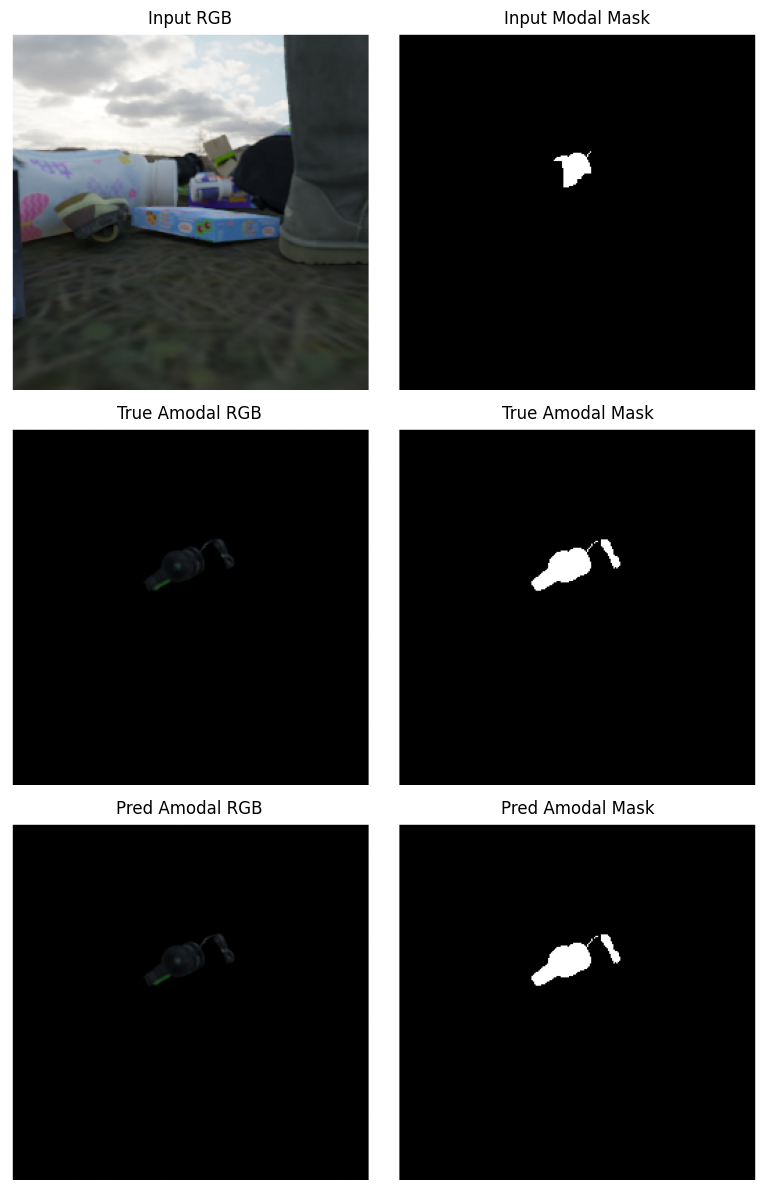

In [120]:
metadata = sample['metadata']
outpath = f"/p/lustre2/marcou1/dsc2025/test_videos/test_sample_{metadata['scene_id']}_{metadata['cam_id']}_obj{metadata['obj_id']}.gif"
make_grid_video_with_titles(grid_tensors,
                            nrows=3, ncols=2,
                            interval=200, 
                            save_path=outpath, title_fontsize=12)

In [155]:

print("Initiating Unet_Image_ConvLSTM training for mask prediction...")

# Clean memory
torch.cuda.empty_cache()
# device = "cpu"

# Send to cuda
model = UnetAmodalMask(mask_content_preds=True, device=device, 
                       mask_weight = 1.0, dice_weight = 0.0, 
                       iou_weight = 0.5, content_weight = 0.0).to(device) # Object-wise ModalMask+RGB -> Object-wise AmodalMask+AmodalContent

# Optimizer - Adam
# optim = torch.optim.Adam(model.parameters(), lr=1e-2)
# Stochastic gradient decent - SGD
optim = torch.optim.SGD(model.parameters(), lr=1e-2)



# Call the train function
n_epochs = 200
list_of_train_metrics, list_of_valid_metrics = train(model, optim, 
                                                     train_dataloader, 
                                                     val_dataloader, 
                                                     n_epochs = n_epochs, 
                                                     device = device,
                                                     print_cuda_malloc=False,
                                                    print_every_n_epoch=10)

Initiating Unet_Image_ConvLSTM training for mask prediction...


Running epochs:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 0 metrics:
+--------------------+------------+--------------+
| Metric - Epoch 0   |   Training |   Validation |
+====================+============+==============+
| loss               |   1.10427  |   1.20364    |
+--------------------+------------+--------------+
| mask_loss          |   0.647751 |   0.708028   |
+--------------------+------------+--------------+
| dice_loss          |   0.839979 |   0.982616   |
+--------------------+------------+--------------+
| iou_loss           |   0.913029 |   0.99123    |
+--------------------+------------+--------------+
| accuracy           |   0.743004 |   0.00864983 |
+--------------------+------------+--------------+
Epoch 10 metrics:
+---------------------+------------+--------------+
| Metric - Epoch 10   |   Training |   Validation |
+=====================+============+==============+
| loss                |   1.25684  |     1.47871  |
+---------------------+------------+--------------+
| mask_loss           |   0.75684  |     0

KeyboardInterrupt: 

In [153]:
metrics = {'train': {}, 'validation': {}}
for key in list_of_train_metrics[0].keys():
    metrics['train'][key] = [list_of_train_metrics[i][key] for i in range(len(list_of_train_metrics))]

for key in list_of_valid_metrics[0].keys():
    metrics['validation'][key] = [list_of_valid_metrics[i][key] for i in range(len(list_of_valid_metrics))]

Text(0.5, 0, 'Epoch')

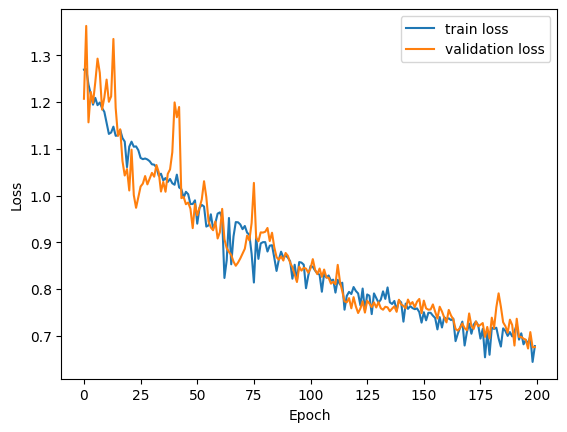

In [154]:
fig, ax = plt.subplots(1,1)

for key in ['train', 'validation']:
    ax.plot(metrics[key]['loss'], label=f'{key} loss')

ax.legend()
ax.set_ylabel("Loss")
ax.set_xlabel("Epoch")

### Launch prod training

In [157]:
# Arguments
learning_rate = 3e-4 # 3e-4?... or 3e-5
batch_size = 4
mask_content_preds = True
n_workers = 1
n_epochs = 20
n_frames = 8

# Dataloaders
# These are specifically for images
# load 1 consecutive frame at a time
train_dataset = MOVi_Dataset_SmartSelect(split = 'train', 
                             n_frames = n_frames,
                             n_samples = 128, 
                             root=ROOT_PATH, metadata_root=metadata_root,
                                     min_modal_pixels_visible = 100,
                                         min_occ_rate = 0.5,
                                         max_occ_rate = 0.8,)
train_dataloader = DataLoader(train_dataset, 
                              num_workers = n_workers, 
                              batch_size=batch_size)

val_dataset = MOVi_Dataset_SmartSelect(split = 'test', 
                           n_frames = n_frames,
                           n_samples = 24,
                          root=ROOT_PATH,
                                   metadata_root=metadata_root,
                                     min_modal_pixels_visible = 100,
                                         min_occ_rate = 0.5,
                                         max_occ_rate = 0.8,)
val_dataloader = DataLoader(val_dataset, 
                            num_workers = n_workers, 
                            batch_size=batch_size)
# val_dataset = train_dataset

# val_dataloader = train_dataloader



Dataset init on train
Init data top dir: /usr/workspace/dssi-dsc/subset_data/train/
Dataset init on test
Init data top dir: /usr/workspace/dssi-dsc/subset_data/test/


#### Check dataset

In [ ]:
sample = next(iter(val_dataset))
sample

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
len(train_dataset)

In [ ]:
# Report on foreground ratio
fg_ratio = []
loader = DataLoader(train_dataset, batch_size=1, shuffle=False)
for batch in tqdm(loader):
    fg_ratio.append(batch['metadata']['foreground_ratio'])

In [ ]:
fg_ratio = np.array(fg_ratio).flatten()
print(np.nanmedian(fg_ratio), np.nanmean(fg_ratio))

In [ ]:
# 1. Take a random sample from your train dataset
idx = random.randint(0, len(val_dataset)-1)
sample = train_dataset[idx]  # sample is a dict

dep = sample['depths'][0][0]
print(dep.min(), dep.max())
plt.imshow(dep)
plt.show()

rgb = sample['frames'][:, 0].permute(1,2,0)
plt.imshow(rgb)
plt.title("RGB")
plt.show()

mmask = sample['modal_masks'][:, 0].permute(1,2,0)
print(mmask.min(), mmask.max())
plt.imshow(mmask, cmap='gray')
plt.title("modal mask")
plt.show()

amask = sample['amodal_masks'][:, 0].permute(1,2,0)
print(amask.min(), amask.max())
plt.imshow(amask, cmap='gray')
plt.title("amodal mask")
plt.show()

plt.imshow(sample['amodal_content'][:, 0].permute(1,2,0))
plt.title("amodal RGB")
plt.show()

In [ ]:
del sample

In [ ]:
del model, optim, list_of_train_metrics, list_of_valid_metrics

In [19]:

torch.cuda.empty_cache()
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |
|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |

#### Start training

In [158]:

print("Initiating Unet_Image_ConvLSTM training for mask prediction...")

# Clean memory
torch.cuda.empty_cache()
# device = "cpu"

# Send to cuda
# Send to cuda
model = UnetAmodalMask(mask_content_preds=True, device=device, 
                       mask_weight = 1.0, dice_weight = 0.0, 
                       iou_weight = 0.5, content_weight = 0.0).to(device) # Object-wise ModalMask+RGB -> Object-wise AmodalMask+AmodalContent

# Optimizer - Adam
optim = torch.optim.Adam(model.parameters(), lr=learning_rate)



# Call the train function
list_of_train_metrics, list_of_valid_metrics = train(model, optim, 
                                                     train_dataloader, 
                                                     val_dataloader, 
                                                     n_epochs = n_epochs, 
                                                     device = device,
                                                     print_cuda_malloc=False,
                                                    print_every_n_epoch=1)

Initiating Unet_Image_ConvLSTM training for mask prediction...


Running epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 metrics:
+--------------------+------------+--------------+
| Metric - Epoch 1   |   Training |   Validation |
+====================+============+==============+
| loss               |   1.19796  |     1.19132  |
+--------------------+------------+--------------+
| mask_loss          |   0.707959 |     0.703458 |
+--------------------+------------+--------------+
| dice_loss          |   0.961    |     0.952855 |
+--------------------+------------+--------------+
| iou_loss           |   0.979994 |     0.975727 |
+--------------------+------------+--------------+
| accuracy           |   0.587235 |     0.629644 |
+--------------------+------------+--------------+
Epoch 2 metrics:
+--------------------+------------+--------------+
| Metric - Epoch 2   |   Training |   Validation |
+====================+============+==============+
| loss               |   1.18227  |     1.17771  |
+--------------------+------------+--------------+
| mask_loss          |   0.696503 |     0.686566

KeyboardInterrupt: 

In [ ]:
metrics = {'train': {}, 'validation': {}}
for key in list_of_train_metrics[0].keys():
    metrics['train'][key] = [list_of_train_metrics[i][key] for i in range(len(list_of_train_metrics))]

for key in list_of_valid_metrics[0].keys():
    metrics['validation'][key] = [list_of_valid_metrics[i][key] for i in range(len(list_of_valid_metrics))]

In [ ]:
fig, ax = plt.subplots(1,1)

for key in ['train', 'validation']:
    ax.plot(metrics[key]['loss'], label=f'{key} loss')

ax.legend()
ax.set_ylabel("Loss")
ax.set_xlabel("Epoch")

#### Visualize

In [ ]:
sys.path.append("../..")
from viz_utils.make_video import make_comparison_grid, make_grid_video_with_titles

In [ ]:
sample = next(iter(val_dataset))
sample

In [ ]:
scene_rgb = sample['frames']
scene_modal_mask = sample['modal_masks']
gt_amodal_rgb = sample['amodal_content']
gt_amodal_mask = sample['amodal_masks']
pred_amodal_rgb = sample['amodal_content']
pred_amodal_mask = sample['amodal_masks']
n_frames=8 


grid_tensors = make_comparison_grid(scene_rgb=scene_rgb, 
                                    scene_modal_mask=scene_modal_mask,
                                    gt_amodal_rgb=gt_amodal_rgb, 
                                    gt_amodal_mask=gt_amodal_mask,
                                    pred_amodal_rgb=pred_amodal_rgb, 
                                    pred_amodal_mask=pred_amodal_mask,
                                    n_frames=8)

In [ ]:
make_grid_video_with_titles(grid_tensors,
                            interval=200, save_path="/p/lustre2/marcou1/dsc2025/test_videos/test_sample_video.gif")

In [ ]:
sample.keys()

In [ ]:
# Run model forward with one sample
# Fake up a batch with bs =1
# Model forward expects
# frames: (bs, c, n_frames, h, w)
# modal_masks: (bs, 1, n_frames, h, w)
input_batch = {'frames': sample['frames'].unsqueeze(0),
              'modal_masks': sample['modal_masks'].unsqueeze(0),
               'amodal_masks': sample['amodal_masks'].unsqueeze(0), 
               'amodal_content': sample['amodal_content'].unsqueeze(0)}

for key, entry in input_batch.items():
    print(key, entry.shape)

In [ ]:
# Run inference
def run_inference_single_sample(model, batch, device):
    """
    Run single sample UnetImage_ConvLSTM inference
    """
    # First things first
    # disable gradient tracking
    with torch.no_grad():
        batch = batch_to_device(batch, device)
        # This takes in a batch - bs =1 for single sample
        # RGB image batch of shape (bs, c, n_frames, h, w)
        # modal_mask (binary, c=1) batch of shape (bs, c, n_frames, h, w)
        # concat rgb and modal masks as input to model

        # frames: (bs, c, n_frames, h, w)
        # modal_masks: (bs, 1, n_frames, h, w)
        frames = batch['frames']         # (bs, c, n_frames, h, w)
        modal_masks = batch['modal_masks']  # (bs, 1, n_frames, h, w)
        frames = modal_masks * frames
        # bs, c, n, h, w = frames.shape


        # # Concatenate along channel dim: (bs, c+1, n_frames, h, w)
        # model_input = torch.cat((frames, modal_masks), dim=1)

        # This time we don't squeeze the time dimension out
        # Prep for loss
        # This is what we use for loss calculations
        # Remember these are bs, c, n, h, w!
        # These both have range 0 to 1 - same to logits
        amodal_mask_labels = batch['amodal_masks'].float()
        amodal_content_labels = batch['amodal_content'].float()

        # Implementation here
        # # Concatenate along channel dim: (bs, c+1, n_frames, h, w)
        # model_input = torch.cat((frames, modal_masks), dim=1)
        x = torch.cat([frames, modal_masks], dim=1)  # (bs, 4, n_frames, h, w)
        bs, c, n_frames, h, w = x.shape
        # Unet_Image encode expects  (bs, 4, n_frames, h, w)
        # Permutation takes (bs, c, n_frames, h, w) --> (bs, n_frames, c, h, w)
        x = x.permute(0, 2, 1, 3, 4)  # (bs, n_frames, c, h, w) --> LSTM expects this

        # Encode frames
        x1_seq, x2_seq, x3_seq, x4_seq = model.encode_frames(x, n_frames)

        # Pass bottleneck (x4_seq) through ConvLSTM
        # Last layer should match dims from encode: torch.Size([6, 256, 1, 16, 16])]
        # ConvLSTM expects B, T, C, H, W
        convlstm_out_list, _ = model.convlstm(x4_seq)  # List of outputs for each layer
        # Returns layer_output_list, last_state_list
        # We only care about the layer output list
        convlstm_out = convlstm_out_list[0]           # (bs, n_frames, channels, h, w)

        # Decoding frames
        # Pass in the sequences of frames and the output of the LSTM
        # Will use the last frame for decoding
        logits_amodal_mask, logits_amodal_content = model.decode_frames(x1_seq, x2_seq, x3_seq, convlstm_out, n_frames)

        # Reshape logits - use permute
        # They come out as bs, n_frames, c, h, w
        # example:
        # torch.Size([8, 8, 3, 256, 256]) torch.Size([8, 8, 1, 256, 256])
        # Batch ground truth is: (bs, c, n_frames, h, w)
        # Example
        # torch.Size([8, 3, 8, 256, 256]) torch.Size([8, 1, 8, 256, 256])
        logits_amodal_mask = logits_amodal_mask.permute(0, 2, 1, 3, 4)
        logits_amodal_content = logits_amodal_content.permute(0, 2, 1, 3, 4)


        # Should we mask the amodal content prediction by the predicted amodal mask?
        if model.mask_content_preds:
            # Element-wise masking by self-predictions:
            logits_amodal_content = logits_amodal_mask.sigmoid().round() * logits_amodal_content

        # print('0000 Verify Shapes 0000')
        # print(logits_amodal_mask.shape)
        # print(logits_amodal_content.shape)
        # print(amodal_mask_labels.shape)
        # print(amodal_content_labels.shape)
        # Loss between predicted amodal masks/content and GT masks/content
        mask_loss, content_loss = model.loss_function(logits_amodal_mask, 
                                                        amodal_mask_labels,
                                                        logits_amodal_content, 
                                                        amodal_content_labels)

        loss = mask_loss + content_loss

        # Compute accuracy
        # If preds are probabilities/logits, binarize them:
        preds_mask = logits_amodal_mask.sigmoid().round() # make binary
        true_mask = amodal_mask_labels.round() # make these binary as well
        # Ensure labels are also float or int for comparison
        # Calculate number of correct pixels
        correct = (preds_mask == true_mask).float().sum()
        # Calculate total number of pixels (numel = number of total elements)
        total = torch.numel(preds_mask)
        # Accuracy
        accuracy = correct / total # this is a number 0 to 1

        # Calculate metrics into a dictionary
        metrics = calculate_metrics(logits_amodal_mask, 
                                    amodal_mask_labels, 
                                    logits_amodal_content,
                                    amodal_content_labels)

        # Report the metrics we calculated in addition to our loss functions
        metrics = {
            'loss': loss.data.item(),
            'mask_loss': mask_loss.data.item(),
            'content_loss': content_loss.data.item(),
            'accuracy': accuracy # add more metrics here - just make sure they are a number
        }
        
    return loss, metrics, logits_amodal_mask, logits_amodal_content

In [ ]:
loss, metrics, logits_amodal_mask, logits_amodal_content = run_inference_single_sample(model=model, batch=input_batch, device=device)

In [ ]:
print("mask", logits_amodal_mask.min(), logits_amodal_mask.max())
print("content", logits_amodal_content.min(), logits_amodal_content.max())
print(metrics)

In [ ]:
logits_amodal_content.shape

In [ ]:
print(gt_amodal_rgb.shape, gt_amodal_mask.shape)

In [ ]:
def convert_output_to_sample_video_input_format(logits_amodal_content, logits_amodal_mask, true_amodal_content, true_amodal_mask):
    """
    Convert single sample Unet evaluation (logits), to plotting ready numpy arrays
    Unet_Image ground truth: true_amodal_content, true_amodal_mask

    Args:
        logits_amodal_content: torch.tensor, [bs, c, n_frames, h, w]
        logits_amodal_mask: torch.tensor [bs, 1, c, n_frames, h, w]
        true_amodal_content: torch.tensor [c, n_frames, h, w]
        true_amodal_mask: torch.tensor [c, n_frames, h, w]

    Returns:
        preds_amodal_content: torch.tensor [c, n_frames, h, w]
        preds_amodal_mask: torch.tensor [c, n_frames, h, w]
    """
    # 1. RGB Content
    # print("AMODAL RGB CONTENT")
    # print("Logits amodal content, initial (after masking): logits amodal content shape", logits_amodal_content.shape, 
    #     "range", logits_amodal_content.min(), logits_amodal_content.max())

    # These are masked amodal contents for the object
    # Apply sigmoid to logits for amodal content (no rounding!)
    logits_amodal_content = logits_amodal_content.sigmoid()
    # print("Logits amodal content, masked and sigmoid applied: logits amodal content shape", logits_amodal_content.shape, 
    #     "range", logits_amodal_content.min(), logits_amodal_content.max())

    # Squeeze to remove the batch dimensions
    preds_amodal_content = logits_amodal_content.squeeze(0)
    # print("Preds Amodal RGB, after squeeze: preds_amodal_content shape", 
    #     preds_amodal_content.shape, "range", preds_amodal_content.min(), preds_amodal_content.max())


    preds_amodal_content = preds_amodal_content.cpu()

    # Apply clip
    preds_amodal_content = torch.clamp(preds_amodal_content, min=0, max=1)

    # Multiply by 255 to get color range
    preds_amodal_content = (preds_amodal_content * 255).to(torch.uint8)     # [0, 255], uint8
    # print("Preds Amodal RGB, after multiply and int: preds_amodal_content shape", 
    #     preds_amodal_content.shape, "range", preds_amodal_content.min(), preds_amodal_content.max())

    print(f"AMODAL CONTENT: true {true_amodal_content.shape}, pred {preds_amodal_content.shape}")
    print("range comparison\n", 
        f"true {true_amodal_content.min()}, {true_amodal_content.max()}\n",
        f"preds {preds_amodal_content.min()}, {preds_amodal_content.max()}\n")

    # check shape
    assert preds_amodal_content.shape == true_amodal_content.shape


    # 2. Amodal Mask
    # print("AMODAL RGB MASK")

    # print("Logits amodal mask, initial: shape", logits_amodal_mask.shape, 
    #     "range", logits_amodal_mask.min(), logits_amodal_mask.max())

    # Apply rounded sigmoids to get integers, binary
    preds_amodal_mask = logits_amodal_mask.sigmoid().round().to(torch.uint8)
    # This yields bs, c, h, w
    # print("Preds amodal mask, after sigmoid: shape", preds_amodal_mask.shape, 
    #     "range", preds_amodal_mask.min(), preds_amodal_mask.max())

    # Drop ix = 0 (batch dimension)
    preds_amodal_mask = preds_amodal_mask.squeeze(0)            # [1, H, W]
    # print("Preds amodal mask, after dropping bs: shape", preds_amodal_mask.shape, 
    #     "range", preds_amodal_mask.min(), preds_amodal_mask.max())

    preds_amodal_mask = preds_amodal_mask.cpu()    # For probability map (grayscale)


    print(f"AMODAL MASK: true {true_amodal_mask.shape}, pred {preds_amodal_mask.shape}")
    print("range comparison\n", 
        f"true {true_amodal_mask.min()}, {true_amodal_mask.max()}\n",
        f"preds {preds_amodal_mask.min()}, {preds_amodal_mask.max()}\n")

    # check shape
    assert preds_amodal_content.shape == true_amodal_content.shape


    return preds_amodal_content, preds_amodal_mask

In [ ]:
preds_amodal_content, preds_amodal_mask = convert_output_to_sample_video_input_format(logits_amodal_content=logits_amodal_content,
                                                                                      logits_amodal_mask=logits_amodal_mask,
                                                                                      true_amodal_content=gt_amodal_rgb,
                                                                                      true_amodal_mask=gt_amodal_mask)


In [ ]:
scene_rgb = sample['frames']
scene_modal_mask = sample['modal_masks']
scene_rgb = sample['frames'] * scene_modal_mask
gt_amodal_rgb = sample['amodal_content']
gt_amodal_mask = sample['amodal_masks']
pred_amodal_rgb = preds_amodal_content
pred_amodal_mask = preds_amodal_mask
n_frames=8 

grid_tensors = make_comparison_grid(scene_rgb=scene_rgb, 
                                    scene_modal_mask=scene_modal_mask,
                                    gt_amodal_rgb=gt_amodal_rgb,
                                    gt_amodal_mask=gt_amodal_mask,
                                    pred_amodal_rgb=pred_amodal_rgb,
                                    pred_amodal_mask=preds_amodal_mask,
                                    n_frames=8)

In [ ]:
sample['metadata']

In [ ]:
# Make video
make_grid_video_with_titles(grid_tensors,
                            interval=200, 
                            save_path="/p/lustre2/marcou1/dsc2025/test_videos/test_sample_inference_{}_{}_{}.gif".format(sample['metadata']['scene'],
                                                                                                                  sample['metadata']['cam_id'],
                                                                                                                   sample['metadata']['obj_id']))